In [124]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
import re
from scipy import stats
from sklearn.neighbors import KernelDensity

In [96]:
df = pd.read_csv('data/ckd.csv', index_col=0)
df.columns = ['age', 'blood_pressure', 'specific_gravity', 'albumin', 'sugar', 'abnormal_red_blood_cells',
              'abnormal_pus_cell', 'pus_cell_clumps', 'bacteria', 'blood_glucose_random', 'blood_urea',
              'serum_creatinine', 'sodium', 'potassium', 'haemoglobin', 'packed_cell_volume', 
              'white_blood_cell_count', 'red_blood_cell_count', 'hypertension', 'diabetes_mellitus', 
              'coronary_artery_disease', 'poor_appetite', 'pedal_edema', 'anemia', 'class']
df.head()

,age,blood_pressure,specific_gravity,albumin,sugar,abnormal_red_blood_cells,abnormal_pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,blood_urea,serum_creatinine,sodium,potassium,haemoglobin,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,poor_appetite,pedal_edema,anemia,class
id,,,,,,,,,,,,,,,,,,,,,,,,,
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,36.0,1.2,NaN,NaN,15.4,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,18.0,0.8,NaN,NaN,11.3,38,6000,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,53.0,1.8,NaN,NaN,9.6,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,56.0,3.8,111.0,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,26.0,1.4,NaN,NaN,11.6,35,7300,4.6,no,no,no,good,no,no,ckd


In [97]:
df['packed_cell_volume'] = pd.to_numeric(df['packed_cell_volume'], errors='coerce')
df['white_blood_cell_count'] = pd.to_numeric(df['white_blood_cell_count'], errors='coerce')
df['red_blood_cell_count'] = pd.to_numeric(df['red_blood_cell_count'], errors='coerce')
df['diabetes_mellitus'].replace(to_replace = {'\tno':'no','\tyes':'yes',' yes':'yes'},inplace=True)
df['coronary_artery_disease'] = df['coronary_artery_disease'].replace(to_replace = '\tno', value='no')
df['class'] = df['class'].replace(to_replace = {'ckd\t': 'ckd', 'notckd': 'not ckd'})

categorical_columns = ['abnormal_red_blood_cells', 'abnormal_pus_cell', 'pus_cell_clumps', 
                       'bacteria', 'hypertension', 'diabetes_mellitus', 'coronary_artery_disease', 
                       'poor_appetite', 'pedal_edema', 'anemia', 'class']

replace_dict = {'normal': 0, 'abnormal': 1, 'notpresent': 0, 'present': 1, 'no': 0, 'yes': 1,
               'good': 0, 'poor': 1, 'not ckd': 0, 'ckd': 1}

for column in categorical_columns:
    df[column] = df[column].replace(replace_dict)

In [98]:
df_knn = pd.get_dummies(df.drop(columns=['class']), dummy_na=True)
scaler = MinMaxScaler(feature_range=(0, 1))
df_knn = pd.DataFrame(scaler.fit_transform(df_knn), columns = df_knn.columns)
knn_imputer = KNNImputer(n_neighbors=3)
df_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(df_knn), columns=df_knn.columns)
df_knn_imputed = scaler.inverse_transform(df_knn_imputed)
df_knn_imputed = pd.DataFrame(df_knn_imputed, columns=df_knn.columns)
df_knn_imputed['class'] = df['class']
df_knn_imputed[categorical_columns] = df_knn_imputed[categorical_columns].round(0)
df_knn_imputed.head()

,age,blood_pressure,specific_gravity,albumin,sugar,abnormal_red_blood_cells,abnormal_pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,blood_urea,serum_creatinine,sodium,potassium,haemoglobin,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,poor_appetite,pedal_edema,anemia,class
0,48.0,80.0,1.020,1.0,0.0,0.0,0.0,0.0,0.0,121.000000,36.0,1.2,139.333333,4.600000,15.4,44.0,7800.0,5.200000,1.0,1.0,0.0,0.0,0.0,0.0,1
1,7.0,50.0,1.020,4.0,0.0,0.0,0.0,0.0,0.0,103.333333,18.0,0.8,141.000000,4.333333,11.3,38.0,6000.0,5.733333,0.0,0.0,0.0,0.0,0.0,0.0,1
2,62.0,80.0,1.010,2.0,3.0,0.0,0.0,0.0,0.0,423.000000,53.0,1.8,138.666667,4.866667,9.6,31.0,7500.0,2.833333,0.0,1.0,0.0,1.0,0.0,1.0,1
3,48.0,70.0,1.005,4.0,0.0,0.0,1.0,1.0,0.0,117.000000,56.0,3.8,111.000000,2.500000,11.2,32.0,6700.0,3.900000,1.0,0.0,0.0,1.0,1.0,1.0,1
4,51.0,80.0,1.010,2.0,0.0,0.0,0.0,0.0,0.0,106.000000,26.0,1.4,138.666667,4.300000,11.6,35.0,7300.0,4.600000,0.0,0.0,0.0,0.0,0.0,0.0,1


In [99]:
df_knn_imputed.to_csv('data/ckd_clean.csv', index=False)

In [100]:
df_clean = pd.read_csv('data/ckd_clean.csv')
df_clean.head()

,age,blood_pressure,specific_gravity,albumin,sugar,abnormal_red_blood_cells,abnormal_pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,blood_urea,serum_creatinine,sodium,potassium,haemoglobin,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,poor_appetite,pedal_edema,anemia,class
0,48.0,80.0,1.020,1.0,0.0,0.0,0.0,0.0,0.0,121.000000,36.0,1.2,139.333333,4.600000,15.4,44.0,7800.0,5.200000,1.0,1.0,0.0,0.0,0.0,0.0,1
1,7.0,50.0,1.020,4.0,0.0,0.0,0.0,0.0,0.0,103.333333,18.0,0.8,141.000000,4.333333,11.3,38.0,6000.0,5.733333,0.0,0.0,0.0,0.0,0.0,0.0,1
2,62.0,80.0,1.010,2.0,3.0,0.0,0.0,0.0,0.0,423.000000,53.0,1.8,138.666667,4.866667,9.6,31.0,7500.0,2.833333,0.0,1.0,0.0,1.0,0.0,1.0,1
3,48.0,70.0,1.005,4.0,0.0,0.0,1.0,1.0,0.0,117.000000,56.0,3.8,111.000000,2.500000,11.2,32.0,6700.0,3.900000,1.0,0.0,0.0,1.0,1.0,1.0,1
4,51.0,80.0,1.010,2.0,0.0,0.0,0.0,0.0,0.0,106.000000,26.0,1.4,138.666667,4.300000,11.6,35.0,7300.0,4.600000,0.0,0.0,0.0,0.0,0.0,0.0,1


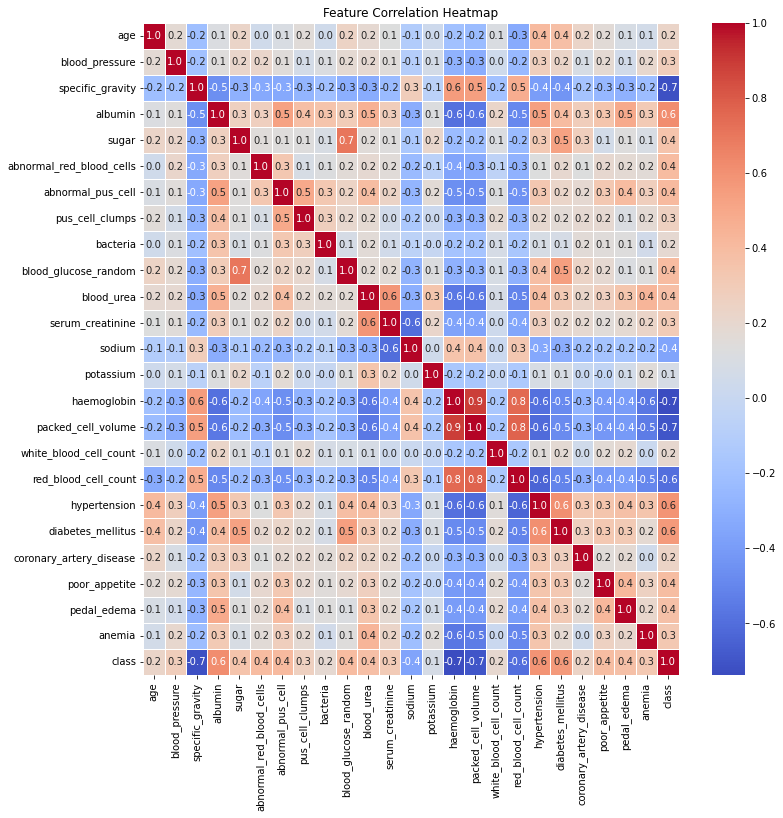

In [101]:
corr_matrix = df_clean.corr()
plt.figure(figsize=(12,12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".1f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [121]:
df_new = pd.read_csv('data/ckd-dataset-v2.csv')
df_new = df_new[2:]
df_new.columns = ['blood_pressure_diastolic', 'blood_pressure_limit', 'specific_gravity', 
                  'albumin', 'class_label', 'abnormal_red_blood_cells', 'sugar', 'abnormal_pus_cell',
                  'pus_cell_clumps', 'bacteria', 'blood_glucose_random', 'blood_urea', 'sodium', 
                  'serum_creatinine', 'potassium', 'haemoglobin', 'packed_cell_volume', 
                  'red_blood_cell_count', 'white_blood_cell_count', 'hypertension', 'diabetes_mellitus', 
                  'coronary_artery_disease', 'poor_appetite', 'pedal_edema', 'anemia', 'grf', 'stage',
                  'class', 'age']

df_new['blood_pressure_diastolic'] = pd.to_numeric(df_new['blood_pressure_diastolic'], errors='coerce')
df_new['abnormal_red_blood_cells'] = pd.to_numeric(df_new['abnormal_red_blood_cells'], errors='coerce')
df_new['abnormal_pus_cell'] = pd.to_numeric(df_new['abnormal_pus_cell'], errors='coerce')
df_new['pus_cell_clumps'] = pd.to_numeric(df_new['pus_cell_clumps'], errors='coerce')
df_new['bacteria'] = pd.to_numeric(df_new['bacteria'], errors='coerce')
df_new['hypertension'] = pd.to_numeric(df_new['hypertension'], errors='coerce')
df_new['diabetes_mellitus'] = pd.to_numeric(df_new['diabetes_mellitus'], errors='coerce')
df_new['coronary_artery_disease'] = pd.to_numeric(df_new['coronary_artery_disease'], errors='coerce')
df_new['poor_appetite'] = pd.to_numeric(df_new['poor_appetite'], errors='coerce')
df_new['pedal_edema'] = pd.to_numeric(df_new['pedal_edema'], errors='coerce')
df_new['anemia'] = pd.to_numeric(df_new['anemia'], errors='coerce')

def assign_blood_pressure(row):
    if row['blood_pressure_diastolic'] == 0:
        return '< 80'
    else:
        return '≥ 80'

df_new['blood_pressure'] = df_new.apply(assign_blood_pressure, axis=1)
df_new = df_new[df_clean.columns]
df_new.head()

,age,blood_pressure,specific_gravity,albumin,sugar,abnormal_red_blood_cells,abnormal_pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,blood_urea,serum_creatinine,sodium,potassium,haemoglobin,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,poor_appetite,pedal_edema,anemia,class
2,< 12,< 80,1.019 - 1.021,1 - 1,< 0,0,0,0,0,< 112,< 48.1,< 3.65,138 - 143,< 7.31,11.3 - 12.6,33.5 - 37.4,7360 - 9740,4.46 - 5.05,0,0,0,0,0,0,1
3,< 12,< 80,1.009 - 1.011,< 0,< 0,0,0,0,0,112 - 154,< 48.1,< 3.65,133 - 138,< 7.31,11.3 - 12.6,33.5 - 37.4,12120 - 14500,4.46 - 5.05,0,0,0,0,0,0,1
4,< 12,< 80,1.009 - 1.011,≥ 4,< 0,1,1,0,1,< 112,48.1 - 86.2,< 3.65,133 - 138,< 7.31,8.7 - 10,29.6 - 33.5,14500 - 16880,4.46 - 5.05,0,0,0,1,0,0,1
5,< 12,≥ 80,1.009 - 1.011,3 - 3,< 0,0,0,0,0,112 - 154,< 48.1,< 3.65,133 - 138,< 7.31,13.9 - 15.2,41.3 - 45.2,7360 - 9740,4.46 - 5.05,0,0,0,0,0,0,1
6,12 - 20,< 80,1.015 - 1.017,< 0,< 0,0,0,0,0,154 - 196,< 48.1,< 3.65,133 - 138,< 7.31,13.9 - 15.2,37.4 - 41.3,7360 - 9740,5.05 - 5.64,0,1,0,1,1,0,1


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'blood_pressure'}>,
        <AxesSubplot:title={'center':'specific_gravity'}>,
        <AxesSubplot:title={'center':'albumin'}>,
        <AxesSubplot:title={'center':'sugar'}>],
       [<AxesSubplot:title={'center':'abnormal_red_blood_cells'}>,
        <AxesSubplot:title={'center':'abnormal_pus_cell'}>,
        <AxesSubplot:title={'center':'pus_cell_clumps'}>,
        <AxesSubplot:title={'center':'bacteria'}>,
        <AxesSubplot:title={'center':'blood_glucose_random'}>],
       [<AxesSubplot:title={'center':'blood_urea'}>,
        <AxesSubplot:title={'center':'serum_creatinine'}>,
        <AxesSubplot:title={'center':'sodium'}>,
        <AxesSubplot:title={'center':'potassium'}>,
        <AxesSubplot:title={'center':'haemoglobin'}>],
       [<AxesSubplot:title={'center':'packed_cell_volume'}>,
        <AxesSubplot:title={'center':'white_blood_cell_count'}>,
        <AxesSubplot:title={'center':'red_blo

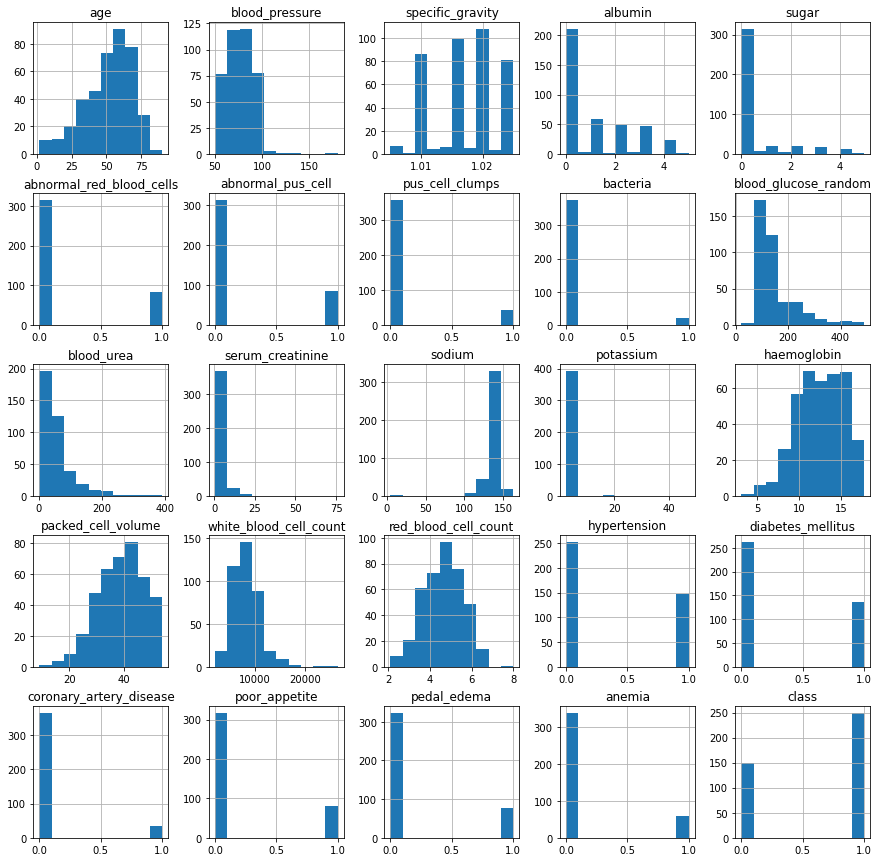

In [103]:
fig, axis = plt.subplots(5,5,figsize=(15, 15))
df_clean.hist(ax=axis)

In [130]:
def kde_rejection_sampling(kde, train_values, lower_bound=None, upper_bound=None, n_samples=100, max_attempts=5):
    accepted_samples = []
    attempts = 0

    while len(accepted_samples) < 1 and attempts < max_attempts:
        x_samples = np.random.uniform(
            train_values.min() if lower_bound is None else lower_bound,
            train_values.max() if upper_bound is None else upper_bound,
            n_samples
        ).reshape(-1, 1)

        # score samples
        log_densities = kde.score_samples(x_samples)
        densities = np.exp(log_densities)

        # normalize
        probs = densities / densities.sum()

        # rejection sampling
        accepted = np.random.choice(
            range(len(x_samples)), 
            size=min(5, len(x_samples)), 
            p=probs, 
            replace=False
        )

        for i in accepted:
            if (lower_bound is None or x_samples[i] >= lower_bound) and \
               (upper_bound is None or x_samples[i] <= upper_bound):
                accepted_samples.append(x_samples[i][0])

        attempts += 1

    # use the midpoint if no accepted samples
    if not accepted_samples:
        if lower_bound is not None and upper_bound is not None:
            return (lower_bound + upper_bound) / 2
        elif lower_bound is not None:
            return lower_bound + 0.01 * (train_values.max() - lower_bound)
        elif upper_bound is not None:
            return upper_bound - 0.01 * (upper_bound - train_values.min())
        else:
            return train_values.mean()
    
    selected = np.random.choice(accepted_samples)
    noise = np.random.normal(0, 0.001 * (train_values.max() - train_values.min()))
    return selected + noise

In [165]:
def synthesize_values(df_new, df_original, categorical_columns=None):
    df_result = df_new.copy()
    
    # create list of categorical columns to replace data for
    if categorical_columns is None:
        categorical_columns = []
        for col in df_new.columns:
            if col in df_clean.columns and pd.api.types.is_string_dtype(df_new[col]):
                sample_values = df_new[col].dropna().sample(min(5, len(df_new[col].dropna()))).values
                for val in sample_values:
                    if isinstance(val, str) and any(x in val for x in ['<', '>', '-', '≤', '≥']):
                        categorical_columns.append(col)
                        break
    
    for col in categorical_columns:
        if col not in df_original.columns:
            print(f"Warning: No column {col} in original dataframe, skipping.")
            continue
            
        train_values = df_original[col].dropna().values.reshape(-1, 1)
        if len(train_values) == 0:
            print(f"Warning: No training values for column {col}, skipping.")
            continue
            
        kde = KernelDensity(kernel='gaussian', bandwidth=np.std(train_values) * 0.3).fit(train_values)
        
        for i in df_result.index:
            value = df_result.loc[i, col]
            
            if not isinstance(value, str):
                continue
            
            lower_bound = None
            upper_bound = None
            
            if '-' in value:
                parts = re.findall(r'([\d\.]+)', value)
                if len(parts) >= 2:
                    lower_bound = float(parts[0])
                    upper_bound = float(parts[1])
            elif '<' in value:
                parts = re.findall(r'([\d\.]+)', value)
                if parts:
                    upper_bound = float(parts[0]) - 1e-10
            elif '>' in value:
                parts = re.findall(r'([\d\.]+)', value)
                if parts:
                    lower_bound = float(parts[0]) + 1e-10
            elif '≤' in value:
                parts = re.findall(r'([\d\.]+)', value)
                if parts:
                    upper_bound = float(parts[0])
            elif '≥' in value:
                parts = re.findall(r'([\d\.]+)', value)
                if parts:
                    lower_bound = float(parts[0])
            
            df_result.loc[i, col] = kde_rejection_sampling(kde, train_values, lower_bound, upper_bound)
    
    return df_result.astype(np.float64)

In [166]:
df_new_result = synthesize_values(df_new, df_clean)
df_new_result.head()

,age,blood_pressure,specific_gravity,albumin,sugar,abnormal_red_blood_cells,abnormal_pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,blood_urea,serum_creatinine,sodium,potassium,haemoglobin,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,poor_appetite,pedal_edema,anemia,class
2,10.870517,60.527995,1.019333,1.003815e+00,-9.900000e-11,0.0,0.0,0.0,0.0,58.664910,19.233151,3.175901,140.036813,4.351928,12.108532,37.119157,7874.826769,4.918282,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,10.306256,74.237048,1.010204,-9.900000e-11,-9.900000e-11,0.0,0.0,0.0,0.0,124.997148,25.793265,3.300576,135.874971,5.647442,12.109345,37.195033,12402.314336,4.929774,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,10.316249,63.968146,1.010844,4.299162e+00,-9.900000e-11,1.0,1.0,0.0,1.0,77.803126,76.137185,1.539077,135.496831,3.780982,9.545014,30.036130,14646.699506,4.659024,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5,5.264249,81.322097,1.009993,3.008171e+00,-9.900000e-11,0.0,0.0,0.0,0.0,120.715759,21.896547,0.948771,133.281595,5.546446,14.861767,41.695860,8126.865614,4.710872,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,19.840084,61.434226,1.016295,-9.900000e-11,-9.900000e-11,0.0,0.0,0.0,0.0,168.301635,27.138968,1.255180,134.107288,4.223187,14.118064,38.200949,7646.549560,5.317540,0.0,1.0,0.0,1.0,1.0,0.0,1.0


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'blood_pressure'}>,
        <AxesSubplot:title={'center':'specific_gravity'}>,
        <AxesSubplot:title={'center':'albumin'}>,
        <AxesSubplot:title={'center':'sugar'}>],
       [<AxesSubplot:title={'center':'abnormal_red_blood_cells'}>,
        <AxesSubplot:title={'center':'abnormal_pus_cell'}>,
        <AxesSubplot:title={'center':'pus_cell_clumps'}>,
        <AxesSubplot:title={'center':'bacteria'}>,
        <AxesSubplot:title={'center':'blood_glucose_random'}>],
       [<AxesSubplot:title={'center':'blood_urea'}>,
        <AxesSubplot:title={'center':'serum_creatinine'}>,
        <AxesSubplot:title={'center':'sodium'}>,
        <AxesSubplot:title={'center':'potassium'}>,
        <AxesSubplot:title={'center':'haemoglobin'}>],
       [<AxesSubplot:title={'center':'packed_cell_volume'}>,
        <AxesSubplot:title={'center':'white_blood_cell_count'}>,
        <AxesSubplot:title={'center':'red_blo

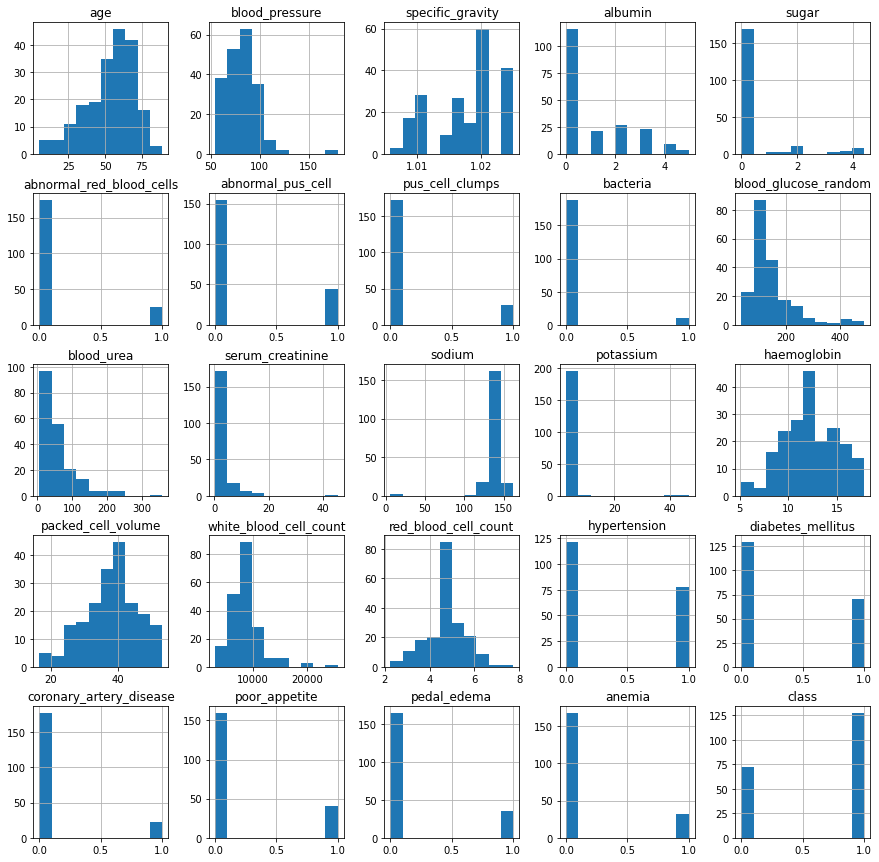

In [169]:
fig, axis = plt.subplots(5,5,figsize=(15, 15))
df_new_result.hist(ax=axis)